Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
from time import time
import matplotlib.pyplot as plt

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


Create a small validation set.

In [4]:
valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99999000 ons anarchists advocate social relations based upon voluntary as
1000  anarchism originated as a term of abuse first used against earl


Utility functions to map characters to vocabulary IDs and back.

In [35]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])
#print("ord of a: ",ord('a')-97+1)

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


from above:
- ' ' = 0
- a = 1
- b = 2
- etc...

Function to generate a training batch for the LSTM model.

In [12]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      ##print("interupt: ",self._text[self._cursor[b]])
      ##print("self cursor: ",self._cursor)
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size      
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    #print("interupt: ",np.array(batches).shape)
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    #print("interupt: ",np.array(batches).shape)
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
    #print("interupt: ",s)
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

interupt:  (1, 64, 27)
['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']
interupt:  (1, 6

In [22]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

questions

- logprob - why divide by labels.shape i.e. the number of letters
- sample distribution makes some sense if np.sum(distribution) = 1
- - the larger a probability the higher the liklihood it will push s over r

Simple LSTM Model.

In [ ]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 200
time0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  print("model run time: %0.3fs"%(time()-time0))

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [ ]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ### all gates
  gx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes*4], -0.1, 0.1))
  gm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  gb = tf.Variable(tf.zeros([1, num_nodes*4]))
  # Forget gate: input, previous output, and bias.
  #fx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  #fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  #fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  #cx = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  #cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  #cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  #ox = tf.Variable(tf.truncated_normal([vocabulary_size, num_nodes], -0.1, 0.1))
  #om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  #ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    #### one gate input,forget,update,ouput
    gates = tf.matmul(i,gx)+tf.matmul(o,gm)+gb
    #input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    #forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    #update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    #state = forget_gate * state + input_gate * tf.tanh(update)
    #output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    state = tf.sigmoid(gates[:,64:128])*state + tf.sigmoid(gates[:,:64])*tf.tanh(gates[:,128:192])
    return tf.sigmoid(gates[:,192:]) * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 200
time0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  print("model run time: %0.3fs"%(time()-time0))

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

In [ ]:
def batch2posit(batch):
  new_batch =[]  
  [new_batch.append(argmax(x)) for x in batch]
  return new_batch
            

In [ ]:
num_nodes = 64
embedding_size = 128

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ### all gates
  gx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  gm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  gb = tf.Variable(tf.zeros([1, num_nodes*4]))
  
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
    
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    #### one gate input,forget,update,ouput: each 64 in size
    #embed = tf.nn.embedding_lookup(embeddings,batch2posit(i))
    #input_data = batch2posit(i)
    embed = tf.nn.embedding_lookup(embeddings,tf.argmax(i,axis=1))
    gates = tf.matmul(embed,gx)+tf.matmul(o,gm)+gb
    state = tf.sigmoid(gates[:,64:128])*state + tf.sigmoid(gates[:,:64])*tf.tanh(gates[:,128:192])
    return tf.sigmoid(gates[:,192:]) * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.int32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 200
time0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  print("model run time: %0.3fs"%(time()-time0))

Problem 2 part 2

In [ ]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])
#print("ord of a: ",ord('a')-97+1)

def bigram2id(bigram):
  return 27*char2id(bigram[0])+char2id(bigram[1])
  
def id2bigram(dictid):
  first = dictid//27
  second = dictid%27
  return id2char(first)+id2char(second)

print(bigram2id('ab'), bigram2id('zg'), bigram2id(' f'), bigram2id('ïg'))
print(id2bigram(2), id2bigram(526), id2bigram(728))

In [ ]:
batch_size=64
num_unrollings=5
vocabulary_size = 729

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      ###print("self._cursor:",self._cursor)
      ###print("b:", b)
      ###print(self._text[self._cursor[b]]+self._text[self._cursor[b]+1])
      ###print(bigram2id(self._text[self._cursor[b]]+self._text[self._cursor[b]+1]))
      ###print("cursor[b+1]:",self._text[self._cursor[(b+1)% self._text_size]])
      batch[b, bigram2id(self._text[self._cursor[b]]+self._text[self._cursor[b]+1])] = 1.0
      #print("interupt: ",self._text[self._cursor[b]])
      self._cursor[b] = (self._cursor[b] + 2) % self._text_size      
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    #print("interupt: ",np.array(batches).shape)
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    #print("interupt: ",np.array(batches).shape)
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2bigram(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
    #print("interupt: ",s)
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

In [ ]:
num_nodes = 64
embedding_size = 128

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ### all gates
  gx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  gm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  gb = tf.Variable(tf.zeros([1, num_nodes*4]))
  
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
    
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    #embed = tf.nn.embedding_lookup(embeddings,batch2posit(i))
    #input_data = batch2posit(i)
    embed = tf.nn.embedding_lookup(embeddings,tf.argmax(i,axis=1))
    gates = tf.matmul(embed,gx)+tf.matmul(o,gm)+gb
    state = tf.sigmoid(gates[:,64:128])*state + tf.sigmoid(gates[:,:64])*tf.tanh(gates[:,128:192])
    return tf.sigmoid(gates[:,192:]) * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.int32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 200
time0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  print("model run time: %0.3fs"%(time()-time0))

Problem 3 part 3: implimenting dropout

In [ ]:
num_nodes = 64
embedding_size = 128
keep_prob = 0.5    


graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ### all gates
  gx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes*4], -0.1, 0.1))
  gm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes*4], -0.1, 0.1))
  gb = tf.Variable(tf.zeros([1, num_nodes*4]))
  
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
    
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  
  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    #embed = tf.nn.embedding_lookup(embeddings,batch2posit(i))
    #input_data = batch2posit(i)
    embed = tf.nn.embedding_lookup(embeddings,tf.argmax(i,axis=1))
    embed_dropout = tf.nn.dropout(embed,keep_prob)
    gates = tf.matmul(embed,gx)+tf.matmul(o,gm)+gb
    state = tf.sigmoid(gates[:,64:128])*state + tf.sigmoid(gates[:,:64])*tf.tanh(gates[:,128:192])
    return tf.nn.dropout(tf.sigmoid(gates[:,192:]),keep_prob) * tf.tanh(state), state

  # Input data.
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.int32, shape=[batch_size,vocabulary_size]))
  train_inputs = train_data[:num_unrollings]
  train_labels = train_data[1:]  # labels are inputs shifted by one time step.

  # Unrolled LSTM loop.
  outputs = list()
  output = saved_output
  state = saved_state
  for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.concat(train_labels, 0), logits=logits))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 200
time0 = time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings + 1):
      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0
      labels = np.concatenate(list(batches)[1:])
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      if step % (summary_frequency * 10) == 0:
        # Generate some samples.
        print('=' * 80)
        for _ in range(5):
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          for _ in range(79):
            prediction = sample_prediction.eval({sample_input: feed})
            feed = sample(prediction)
            sentence += characters(feed)[0]
          print(sentence)
        print('=' * 80)
      # Measure validation set perplexity.
      reset_sample_state.run()
      valid_logprob = 0
      for _ in range(valid_size):
        b = valid_batches.next()
        predictions = sample_prediction.eval({sample_input: b[0]})
        valid_logprob = valid_logprob + logprob(predictions, b[1])
      print('Validation set perplexity: %.2f' % float(np.exp(
        valid_logprob / valid_size)))
  print("model run time: %0.3fs"%(time()-time0))

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

In [75]:
batch_size=64
num_unrollings=10

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]
    self._last_batch = self._next_batch()
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, char2id(self._text[self._cursor[b]])] = 1.0
      ##print("interupt: ",self._text[self._cursor[b]])
      ##print("self cursor: ",self._cursor)
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size      
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    ##print("interupt: ",np.array(batches).shape)
    for step in range(self._num_unrollings-1):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    #print("interupt: ",np.array(batches).shape)
    return batches

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0]
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))]
    #print("interupt: ",s)
  return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarch', 'when milit', 'lleria arc', ' abbeys an', 'married ur', 'hel and ri', 'y and litu', 'ay opened ', 'tion from ', 'migration ', 'new york o', 'he boeing ', 'e listed w', 'eber has p', 'o be made ', 'yer who re', 'ore signif', 'a fierce c', ' two six e', 'aristotle ', 'ity can be', ' and intra', 'tion of th', 'dy to pass', 'f certain ', 'at it will', 'e convince', 'ent told h', 'ampaign an', 'rver side ', 'ious texts', 'o capitali', 'a duplicat', 'gh ann es ', 'ine januar', 'ross zero ', 'cal theori', 'ast instan', ' dimension', 'most holy ', 't s suppor', 'u is still', 'e oscillat', 'o eight su', 'of italy l', 's the towe', 'klahoma pr', 'erprise li', 'ws becomes', 'et in a na', 'the fabian', 'etchy to r', ' sharman n', 'ised emper', 'ting in po', 'd neo lati', 'th risky r', 'encycloped', 'fense the ', 'duating fr', 'treet grid', 'ations mor', 'appeal of ', 'si have ma']
['hists advo', 'tary gover', 'ches natio', 'nd monaste', 'rraca prin', 'ichard bae', 'urgical la', ' fo

In [105]:
embedding_size = 128
vocabulary_size = 27
num_nodes_1 = 128

graph = tf.Graph()
with graph.as_default():    

	#Variables
	gx = tf.Variable(tf.truncated_normal([embedding_size,num_nodes_1*4]))
	gb = tf.Variable(tf.truncated_normal([1,num_nodes_1*4]))

	gx_2 = tf.Variable(tf.truncated_normal([num_nodes_1,num_nodes_1*4]))
	gb_2 = tf.Variable(tf.truncated_normal([1,num_nodes_1*4]))

	w = tf.Variable(tf.truncated_normal([num_nodes_1,vocabulary_size]))
	b = tf.Variable(tf.zeros([vocabulary_size]))

	embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size],-1.0,1.0))
	
	#Placeholders
	train_data = list()
	for _ in range(num_unrollings):
		train_data.append(tf.placeholder(tf.int32,shape = [batch_size,vocabulary_size]))
	##train_input = train_data[:num_unrollings]
	##train_labels = train_data[1:]

	#Constants #to be placeholders later?
	saved_output_1 = tf.constant(np.zeros([batch_size,num_nodes_1],dtype = np.float32))
	saved_state_1 = tf.constant(np.zeros([batch_size,num_nodes_1],dtype = np.float32))

	#lstm
	def lstm_cell_1(i,state):
		embed = tf.nn.embedding_lookup(embeddings,tf.argmax(i,axis=1))
		gates = tf.matmul(embed,gx)+gb
		state = tf.sigmoid(gates[:,num_nodes_1:num_nodes_1*2]
			)*state+tf.sigmoid(gates[:,:num_nodes_1])*tf.tanh(gates[:,num_nodes_1*2:num_nodes_1*3])
		return tf.sigmoid(gates[:,num_nodes_1*3:])*tf.tanh(state),state

	def lstm_cell_2(o,state):
		#embed = tf.nn.embedding_lookup(embeddings,tf.argmax(i,axis=1))
		gates = tf.matmul(o,gx_2)+gb_2
		state = tf.sigmoid(gates[:,num_nodes_1:num_nodes_1*2]
			)*state+tf.sigmoid(gates[:,:num_nodes_1])*tf.tanh(gates[:,num_nodes_1*2:num_nodes_1*3])
		return tf.sigmoid(gates[:,num_nodes_1*3:])*tf.tanh(state),state

	#running through lstm_1	
	state = saved_state_1
	for i in reversed(train_data):
		_,state = lstm_cell_1(i,state)
		#outputs.append(output)

	#running through lstm_2
	outputs = list()
	output = saved_output_1
	for i in range(num_unrollings):
		output,state = lstm_cell_2(output,state)
		outputs.append(output)

	#classifier
	logits = tf.nn.xw_plus_b(tf.concat(outputs,0),w,b)
	loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
		labels = tf.concat(train_data,0), logits = logits))

	#optimizer
	global_step = tf.Variable(0)
	learning_rate = tf.train.exponential_decay(
		10.0,global_step,5000,0.1,staircase=True)
	optimizer = tf.train.GradientDescentOptimizer(learning_rate)
	gradients,v = zip(*optimizer.compute_gradients(loss))
	gradients,_ = tf.clip_by_global_norm(gradients,1.25)
	optimizer = optimizer.apply_gradients(zip(gradients,v),global_step = global_step)

	#predictions
	train_prediction = tf.nn.softmax(logits)

In [107]:
num_steps = 7001
summary_frequency = 200
t0 = time()

log =[]

with tf. Session(graph=graph) as sess:
  tf.global_variables_initializer().run()
  print("Initialised")
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = dict()
    for i in range(num_unrollings):
      feed_dict[train_data[i]] = batches[i]
    _,l,predictions,lr = sess.run(
      [optimizer,loss,train_prediction,learning_rate],feed_dict =feed_dict)
    mean_loss +=l
    if step%summary_frequency ==0:
      if step>0:
        mean_loss = mean_loss/summary_frequency
        print("Average loss at step %d: %f learning_rate %f"%(step,mean_loss,lr))
        labels = np.concatenate(list(batches))
        log.append((step,np.exp(logprob(predictions,labels)),mean_loss))
        mean_loss = 0        
        print("Minibatch perplexity: %.2f"%float(np.exp(logprob(predictions,labels))))        
        if step%(summary_frequency*3) == 0:
          print('='*50)
          for j in range(2):					
            prediction_out = np.ndarray(shape = num_unrollings,dtype = 'U1')
            target_out = np.ndarray(shape = num_unrollings,dtype = 'U1')            
            for k in range(num_unrollings):
              ##print('data_type: ',type(np.argmax(predictions[k*64+j])))
              prediction_out[k] = id2char(np.argmax(predictions[k*64+j]))
              target_out[k] = id2char(np.argmax(labels[k*64+j]))
            print("target: ", target_out)
            print("predic: ",prediction_out)
            print('='*50)

print("model run time: %im: %0.1fs"%((time()-t0)//60,(time()-t0)%60))

Initialised
Average loss at step 200: 3.227002 learning_rate 18.726583
Minibatch perplexity: 9.56
Average loss at step 400: 2.258355 learning_rate 17.534248
Minibatch perplexity: 9.22
Average loss at step 600: 2.065650 learning_rate 16.417830
Minibatch perplexity: 7.47
target:  ['k' 'n' 'o' 'w' 'n' ' ' 'a' 's' ' ' 'p']
predic:  ['k' 'i' 'o' 'n' 'n' 'n' 'i' 'i' 'i' 'i']
target:  [' ' 'p' 'o' 'p' ' ' 'a' 'r' 't' 'i' 's']
predic:  [' ' 'p' 'p' 'p' 'i' 'p' 'r' 'r' 'r' 'e']
Average loss at step 800: 1.943746 learning_rate 15.372492
Minibatch perplexity: 7.05
Average loss at step 1000: 1.851191 learning_rate 14.393713
Minibatch perplexity: 7.06
Average loss at step 1200: 1.796903 learning_rate 13.477254
Minibatch perplexity: 5.71
target:  ['e' 'f' 'o' 'r' 'm' 'e' 'd' ' ' 'i' 'n']
predic:  ['e' 'y' 'e' 'r' ' ' ' ' ' ' ' ' ' ' ' ']
target:  ['e' 'c' 't' ' ' 't' 'h' 'e' 'm' ' ' 'a']
predic:  ['e' 'c' 't' ' ' 't' 'h' 'e' 'e' 'e' ' ']
Average loss at step 1400: 1.734635 learning_rate 12.619147
Mi

num_steps = 25001

learning rate started at 10 and halfed every 5000 (staircase)

num_nodes_1 = 256

Average loss at step 25000: 1.281596 learning_rate 0.312500

Minibatch perplexity: 3.80

model run time: 44m: 47.0s


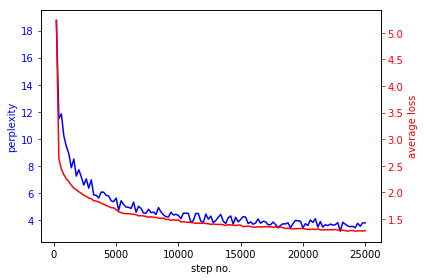

In [84]:
log2=np.array(log)

fig, ax1 = plt.subplots()
ax1.plot(np.array(log2[:,0]), np.array(log2[:,1]), 'b-')
ax1.set_xlabel("step no.")
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('perplexity', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(np.array(log2[:,0]), np.array(log2[:,2]), 'r-')
ax2.set_ylabel('average loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()



Reversed the encoder!!!

num_steps = 11001

learning rate started at 10 and *0.3 every 5000 (staircase)

num_nodes_1 = 128

Average loss at step 11000: 0.841077 learning_rate 0.900000

Minibatch perplexity: 2.19

model run time: 8m: 50.1s

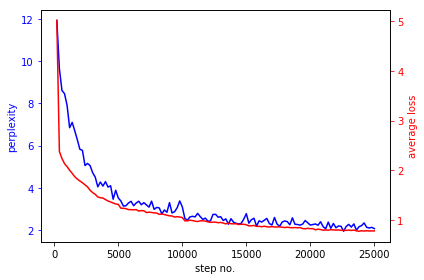

In [100]:
log2=np.array(log)

fig, ax1 = plt.subplots()
ax1.plot(np.array(log2[:,0]), np.array(log2[:,1]), 'b-')
ax1.set_xlabel("step no.")
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('perplexity', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(np.array(log2[:,0]), np.array(log2[:,2]), 'r-')
ax2.set_ylabel('average loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

Reversed the encoder!!! -- The output for this model was deleted!!! a little better than the smaller model

num_steps = 11001

learning rate started at 10 and *0.55 every 5000 (staircase)

num_nodes_1 = 256

Average loss at step 25000: 0.779838 learning_rate 0.503284

Minibatch perplexity: 2.07

model run time: 44m: 59.6s

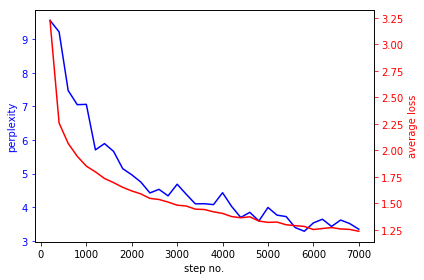

In [110]:
log2=np.array(log)

fig, ax1 = plt.subplots()
ax1.plot(np.array(log2[:,0]), np.array(log2[:,1]), 'b-')
ax1.set_xlabel("step no.")
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('perplexity', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(np.array(log2[:,0]), np.array(log2[:,2]), 'r-')
ax2.set_ylabel('average loss', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()